In [1]:
import pymc as pm
import aesara
from aesara import tensor as at

import arviz as az
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import pymc_statespace as pmss

config = {'figure.figsize':[12.0, 4.0],
          'figure.dpi':72.0 * 2,
          'figure.facecolor':'w',
          'axes.grid':True,
          'grid.linewidth':0.5,
          'grid.linestyle':'--',
          'axes.spines.top':False,
          'axes.spines.bottom':False,
          'axes.spines.left':False,
          'axes.spines.right':False}

plt.rcParams.update(config)

# Synthetic Data - ARMA(1,1)

Start very simple because I don't want to worry about stationarity at higher orders of p,q 

In [2]:
AR_params = [0.8, 0.0]
MA_params = [-0.5]

# Initial state
x0 = np.r_[[0.0], [0.0]]

# Hidden state transition matrix 
T = np.array([[AR_params[0], 1.0],
              [AR_params[1], 0.0]])

# Hidden state noise coefficients
R = np.array([[1.0],
              [MA_params[0]]])

# Hidden state covaraince matrix
Q = np.array([[0.8]])

# Observation matrix
Z = np.array([[1.0, 0.0]])

# Observation noise covariance
H = np.array([[0.0]])

timesteps = 100
data = np.zeros(timesteps)
hidden_states = np.zeros((timesteps, 2))
hidden_states[0, :] = x0

innovations = np.random.multivariate_normal(mean=np.array([0.0]), cov=Q, size=timesteps)

for t in range(1, timesteps):
    hidden_states[t] = T @ hidden_states[t-1, :] + R @ np.atleast_1d(innovations[t])
    data[t] = Z @ hidden_states[t]


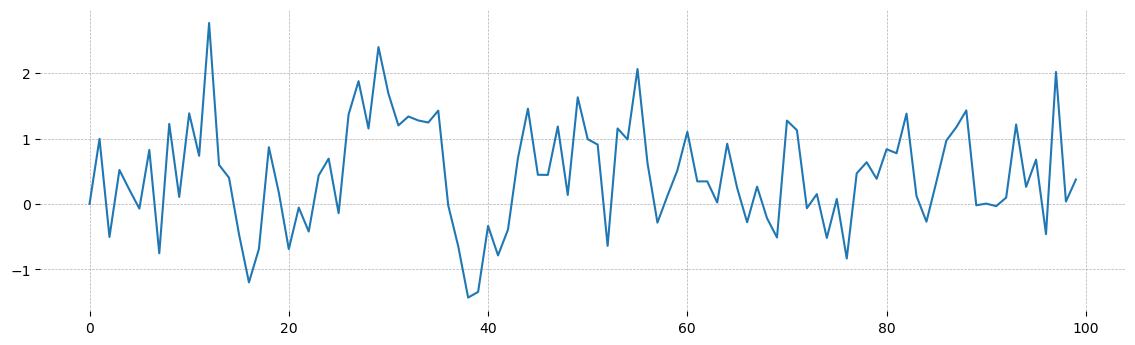

In [3]:
fig, ax = plt.subplots(figsize=(14,4), dpi=100)
ax.plot(data)
plt.show()

# Statsmodels

In [4]:
mod = sm.tsa.SARIMAX(endog=data, order=(1, 0, 1))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -118.002
Date:                Sun, 08 May 2022   AIC                            242.004
Time:                        18:53:37   BIC                            249.819
Sample:                             0   HQIC                           245.167
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7946      0.110      7.210      0.000       0.579       1.011
ma.L1         -0.4189      0.156     -2.678      0.007      -0.725      -0.112
sigma2         0.6178      0.096      6.415      0.000       0.429       0.807
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                 2.02
Prob(Q):                              0.46   Prob(JB):                         0.36
Heteroskedasticity (H):               0.70   Skew:                             0.27
Prob(H) (two-sided):                  0.30   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# PyMC

In [5]:
model = pmss.BayesianARMA(data = data[:, None], order=(1, 1))

In [6]:
coords = {'all_states':['data', 'L1.data'],
          'random_states':['data'],
          'ar_params':['rho_1'],
          'ma_params':['theta_1']}

with pm.Model(coords=coords) as arma_model:
    x0 = pm.Normal('initial_states', mu=0.0, sigma=1.0, dims=['all_states'])
    state_sigmas = pm.HalfNormal('state_sigma', sigma=1.0, dims=['random_states'])
    
    initial_sigma = pm.HalfNormal('initial_sigma', sigma=1.0, dims=['all_states'])
    P0 = np.eye(2) * initial_sigma
        
    rhos = pm.TruncatedNormal('rho', mu=0.0, sigma=0.5, lower=-1.0, upper=1.0, dims=['ar_params'])
    thetas = pm.Normal('thetas', mu=0.0, sigma=0.5, dims=['ma_params'])
    
    params = at.concatenate([x0.ravel(), P0.ravel(), state_sigmas.ravel(), rhos.ravel(), thetas.ravel()])
    model.build_statespace_graph(params)

    likelihood = pm.Potential("likelihood", model.log_likelihood)
    y_hat = pm.Deterministic('y_hat', model.filtered_states)
    cov_hat = pm.Deterministic('cov_hat', model.filtered_covarainces)
    
    prior_params = pm.sample_prior_predictive(var_names=['y_hat', 'cov_hat'])

C:\Users\Jesse\AppData\Local\Temp\ipykernel_21260\3054298551.py:23: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior_params = pm.sample_prior_predictive(var_names=['y_hat', 'cov_hat'])
C:\Users\Jesse\miniconda3\envs\pymc_dev\lib\site-packages\pymc\aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
WARNING (aesara.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make s

These "prior" plots don't really show the priors, they show model uncertainty around kalman filter predictions given the priors. True prior plots would simulate draws from a multivariate normal and generate new data....

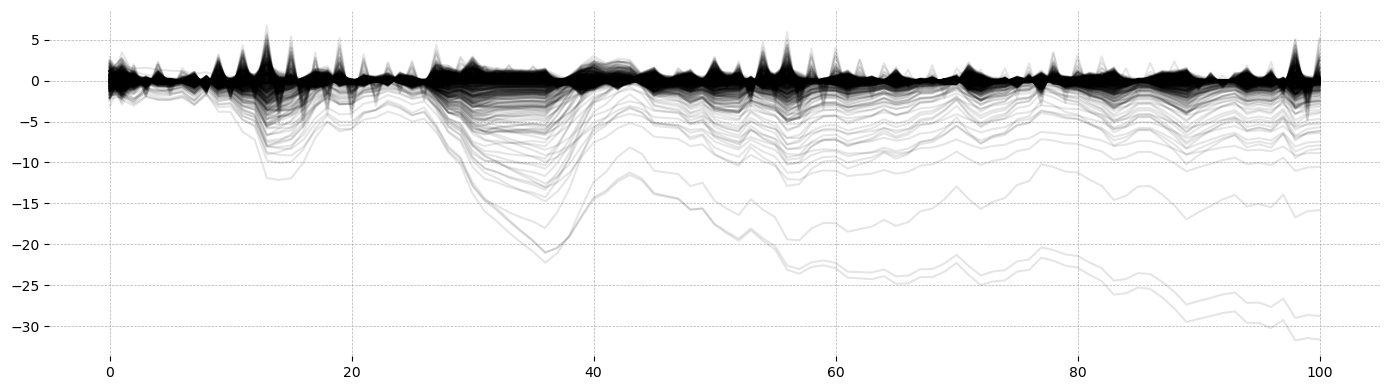

In [7]:
prior_mean = prior_params.prior['y_hat'].squeeze()
prior_cov = prior_params.prior['cov_hat'].squeeze()

fig, ax = plt.subplots(figsize=(14,4), dpi=100)

# ci_bounds = 1.96 * np.einsum('stk,stkj->stk', prior_mean, prior_cov)
# upper = np.quantile(prior_mean + ci_bounds, 0.95, axis=0)
# lower = np.quantile(prior_mean - ci_bounds, 0.05, axis=0)

x_values_plus = np.arange(timesteps + 1)

ax.plot(x_values_plus, prior_mean[:, :, 0].T, color='k', alpha=0.1)
# ax.fill_between(x_values_plus, y1=lower[:, 0], y2=upper[:, 0], color='tab:blue', alpha=0.1)

fig.tight_layout()
plt.show()

# Estimation

Divergences even with target_accept cranked up to 0.99, womp womp.

In [8]:
with arma_model:
    trace = pm.sample(cores=6, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Jesse\miniconda3\envs\pymc_dev\lib\site-packages\pymc\aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [initial_states, state_sigma, initial_sigma, rho, thetas]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 820 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


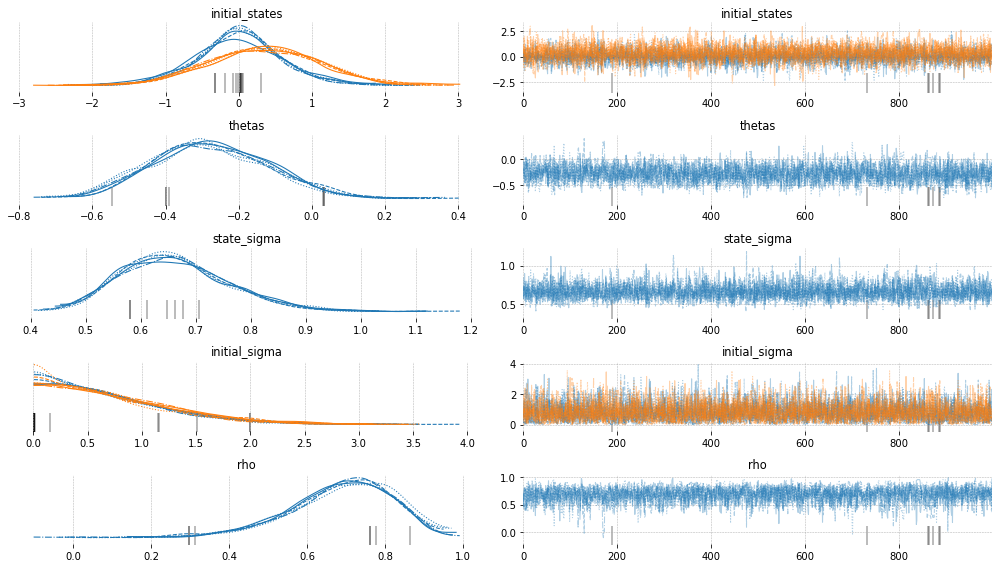

In [13]:
fig, ax = plt.subplots(5, 2, figsize=(14,8))
az.plot_trace(trace, var_names=['~y_hat', '~cov_hat'], axes=ax);
fig.tight_layout()
plt.show()

Estimation of the initial states and sigmas appears to be the problem; notice how all the divergences are at the 0,0 tip of "fan" in plot at position (3, 0).

Something better needs to be done with these. In principal one should be able to estimate them like anything else, but in practice they seem to be getting in the way.

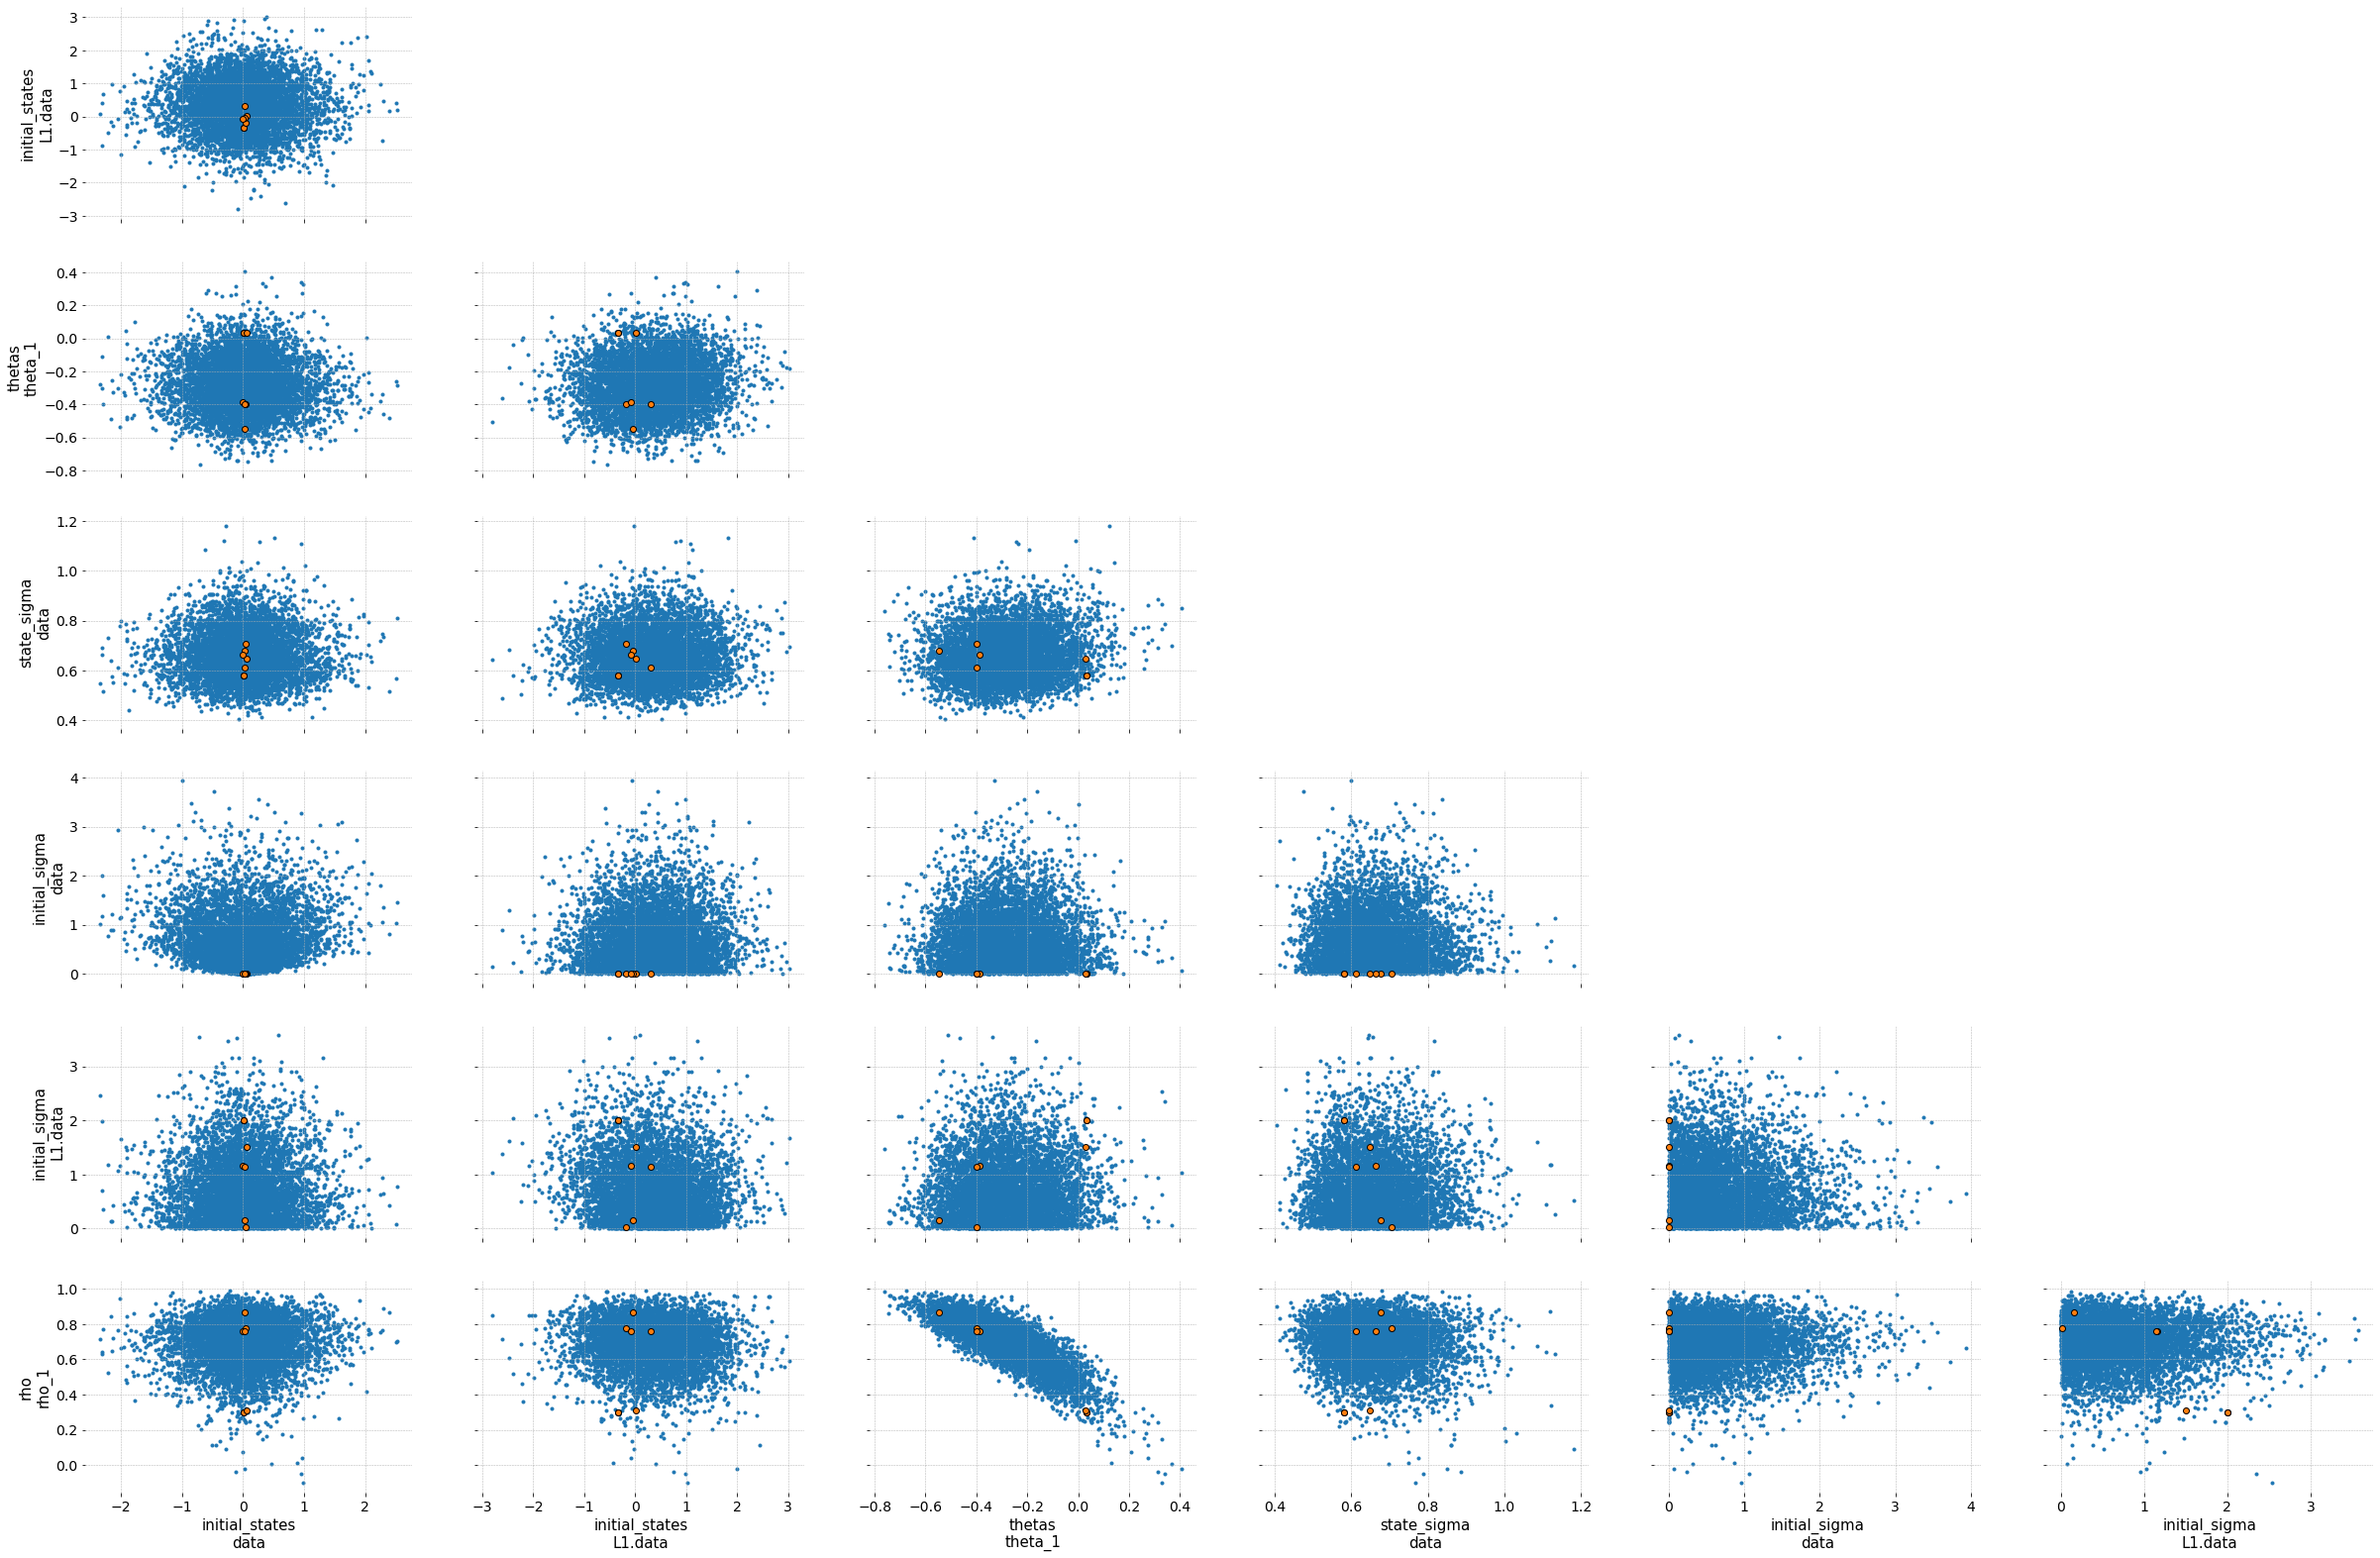

In [25]:
az.plot_pair(trace, var_names=['~y_hat', '~cov_hat'], divergences=True);

Posterior estimates are reasonable, and the true value is contained in the 94% HDI in each case. Looks like the ML estimator did a bit better, but we also estimated 4 more parameters than it did (2 initial states, plus 2 initial covariances!)

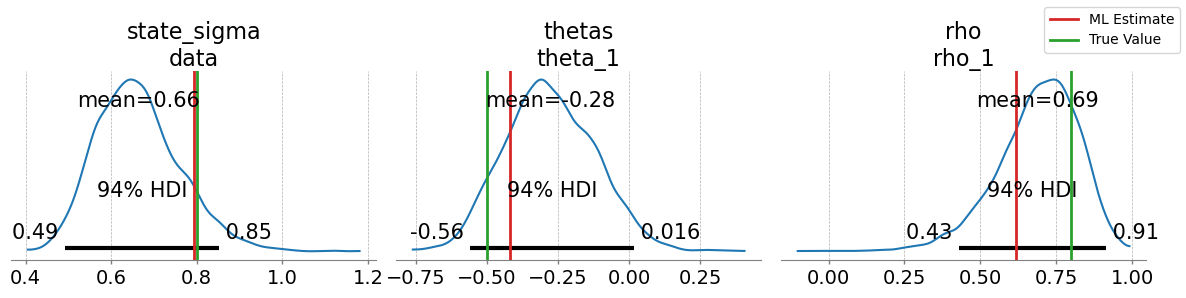

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(12,3), dpi=100)
az.plot_posterior(trace, var_names=['state_sigma', 'thetas', 'rho'], ax=ax)
ax[0].axvline(res.params[0], color='tab:red', lw=2, label='ML Estimate')
ax[1].axvline(res.params[1], color='tab:red', lw=2)
ax[2].axvline(res.params[2], color='tab:red', lw=2)

ax[0].axvline(0.8, color='tab:green', lw=2, label='True Value')
ax[1].axvline(-0.5, color='tab:green', lw=2)
ax[2].axvline(0.8, color='tab:green', lw=2)


fig.set(facecolor='white')
fig.tight_layout()
fig.legend()
plt.show()

In [29]:
with arma_model:
    post_pred = pm.sample_posterior_predictive(trace, var_names=['y_hat', 'cov_hat'])

C:\Users\Jesse\AppData\Local\Temp\ipykernel_21260\2780455798.py:2: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  post_pred = pm.sample_posterior_predictive(trace, var_names=['y_hat', 'cov_hat'])


In [30]:
post_mean = post_pred.posterior_predictive.stack(dict(idx = ['chain', 'draw']))['y_hat'].squeeze().transpose('idx', 'y_hat_dim_0', 'y_hat_dim_1')
post_cov = post_pred.posterior_predictive.stack(dict(idx = ['chain', 'draw']))['cov_hat'].squeeze().transpose('idx', 'cov_hat_dim_0', 'cov_hat_dim_1', 'cov_hat_dim_2')

As above, this isn't really a posterior predictive plot, it's more like posterior model uncertainty.

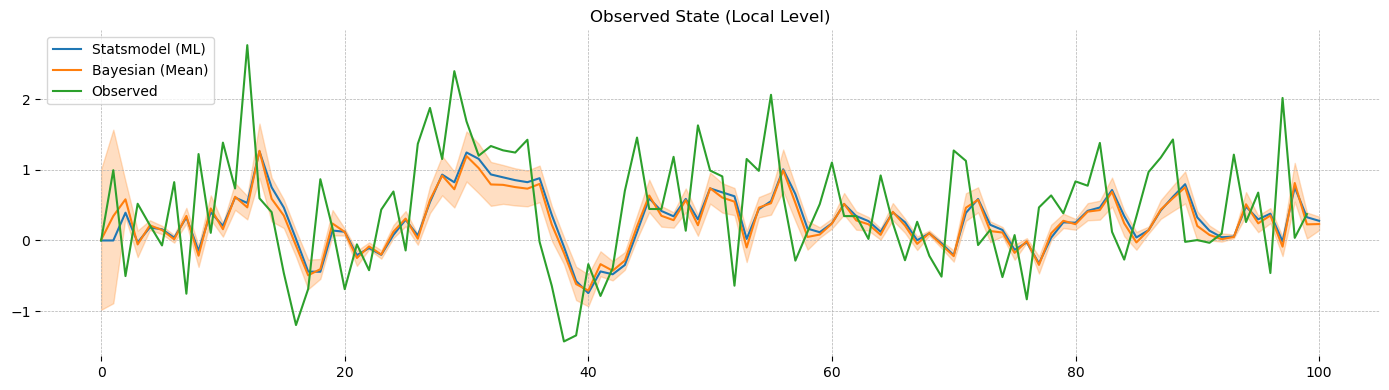

In [48]:
fig, ax = plt.subplots(figsize=(14,4), dpi=100)
x_values = np.arange(timesteps)
x_values_plus = np.arange(timesteps + 1)
ax.plot(x_values_plus, res.states.predicted[:, 0], label='Statsmodel (ML)')
ax.plot(x_values_plus, post_mean.mean(axis=0)[:, 0], label='Bayesian (Mean)')
ax.fill_between(x_values_plus,
                   post_mean.quantile(0.05, dim=['idx'])[:, 0],
                   post_mean.quantile(0.95, dim=['idx'])[:, 0],
                   alpha=0.25, color='tab:orange')
ax.plot(x_values, data, label='Observed')
ax.set(title='Observed State (Local Level)')
ax.legend()

fig.set(facecolor='white')
fig.tight_layout()
plt.show()